In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [31]:
from fbprophet import Prophet


In [83]:
all_data = pd.read_csv("../input/train_1.csv").T
key = pd.read_csv("../input/key_1.csv")

In [84]:
#Handle N/A
train, test = all_data.iloc[0:-N,:], all_data.iloc[-N:,:]

test_cleaned = test.T.fillna(method='ffill').T
train_cleaned = train.T.iloc[:,1:].fillna(method='ffill').T

In [244]:
N = 60 # number of days for test split
i = 1800 # one example time series to train

In [245]:
#fill outliers that are out of 1.5*std with rolling median of 56 days
data=train_cleaned.iloc[:,i].to_frame()
data.columns = ['visits']
data['median'] = pd.rolling_median(data.visits,50,min_periods=1)
std_mult = 1.5
data.ix[np.abs(data.visits-data.visits.median())>=(std_mult*data.visits.std()),'visits'] = data.ix[np.abs(data.visits-data.visits.median())>=(std_mult*data.visits.std()),'median']
data.index = pd.to_datetime(data.index)

print(data.tail())

            visits  median
2016-10-28    12.0     6.0
2016-10-29     8.0     6.0
2016-10-30    11.0     6.0
2016-10-31    13.0     6.0
2016-11-01     8.0     6.5


/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=50,center=False).median()
/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [246]:
#prophet expects the folllwing label names
X = pd.DataFrame(index=range(0,len(data)))
X['ds'] = data.index
X['y'] = data['visits'].values
X.tail()

ds     y
485 2016-10-28  12.0
486 2016-10-29   8.0
487 2016-10-30  11.0
488 2016-10-31  13.0
489 2016-11-01   8.0

In [247]:
m = Prophet(yearly_seasonality=False,weekly_seasonality=True)
m.fit(X)
future = m.make_future_dataframe(periods=N,include_history=True)
future.tail()

ds
545 2016-12-27
546 2016-12-28
547 2016-12-29
548 2016-12-30
549 2016-12-31

In [248]:
future.shape,X.shape

((550, 1), (490, 2))

In [249]:
%time forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

CPU times: user 2.46 s, sys: 0 ns, total: 2.46 s
Wall time: 2.46 s


ds      yhat  yhat_lower  yhat_upper
545 2016-12-27  7.943129    4.222562   11.456026
546 2016-12-28  7.707694    4.111175   11.644225
547 2016-12-29  7.759909    4.265483   11.534874
548 2016-12-30  7.604597    4.051823   11.183503
549 2016-12-31  8.630161    4.559153   12.208917

In [250]:
145063*4.11/3600/19

8.716504824561405

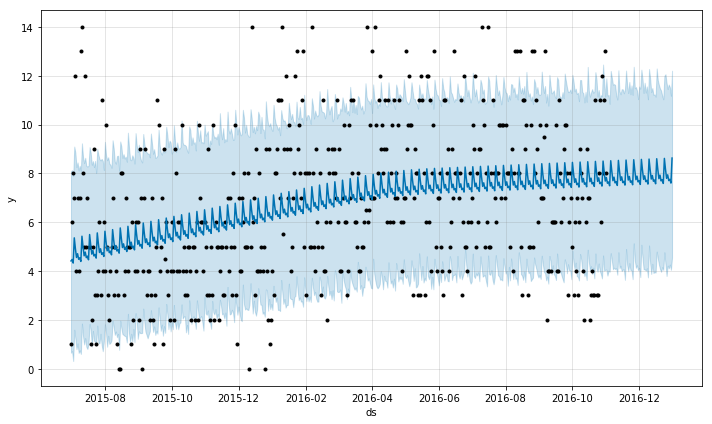

In [251]:
m.plot(forecast);

In [252]:
y_truth = test_cleaned.iloc[:,i].values
y_forecasted = forecast.iloc[-N:,2].values


denominator = (np.abs(y_truth) + np.abs(y_forecasted))
diff = np.abs(y_truth - y_forecasted) / denominator
diff[denominator == 0] = 0.0
print(200 * np.mean(diff))

40.7038316062


In [253]:
print(200 * np.median(diff))

27.4787259722


In [254]:
X.y=np.log(X.y+1)

In [255]:
m = Prophet(yearly_seasonality=False,weekly_seasonality=True)
m.fit(X)
future = m.make_future_dataframe(periods=N,include_history=True)
future.tail()

ds
545 2016-12-27
546 2016-12-28
547 2016-12-29
548 2016-12-30
549 2016-12-31

In [256]:
future.shape,X.shape

((550, 1), (490, 2))

In [257]:
%time forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

CPU times: user 3.64 s, sys: 0 ns, total: 3.64 s
Wall time: 3.64 s


ds      yhat  yhat_lower  yhat_upper
545 2016-12-27  2.098218    1.503698    2.678757
546 2016-12-28  2.049595    1.454629    2.576239
547 2016-12-29  2.085357    1.545549    2.654461
548 2016-12-30  2.003520    1.435048    2.592279
549 2016-12-31  2.179991    1.605126    2.745141

In [258]:
145063*4.11/3600/19

8.716504824561405

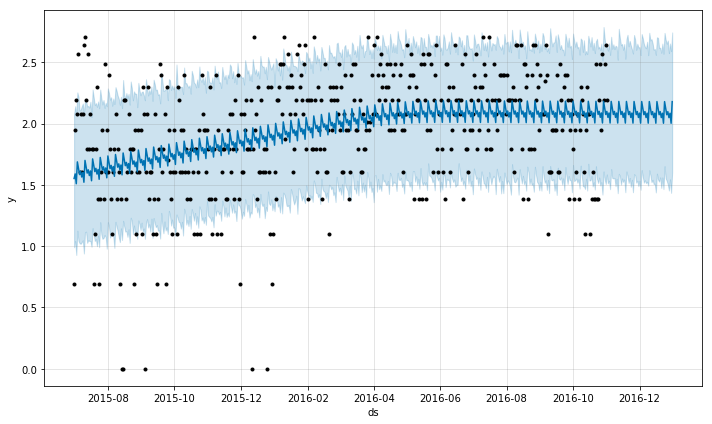

In [259]:
m.plot(forecast);

In [260]:
y_truth = test_cleaned.iloc[:,i].values
y_forecasted = np.exp(forecast.iloc[-N:,2].values)-1


denominator = (np.abs(y_truth) + np.abs(y_forecasted))
diff = np.abs(y_truth - y_forecasted) / denominator
diff[denominator == 0] = 0.0
print(200 * np.mean(diff))

37.6692753505


In [261]:
print(200 * np.median(diff))

34.207380191


In [50]:
a=pd.read_csv("../submission/ab_mean.csv.gz",index_col=0)
b=pd.read_csv("../submission/sub_pred_lstm1_60.csv.gz",index_col=0)

In [51]:
a.shape,b.shape

((8703780, 1), (8703780, 1))

In [60]:
a.head(),b.head()

(               Visits
 Id                   
 00000004df28    26.35
 0000009ee908     9.40
 00000138c1d4   644.20
 0000037f6ad4  1278.20
 000004e572e4    22.55,               Visits
 Id                  
 ff8c1aade3de    18.3
 3da6fd5b23c1    19.2
 cd9e83803be4     4.7
 65cd4af0968c    13.4
 75bae1fb2637    10.6)

In [61]:
np.corrcoef(a.Visits.values,b.loc[a.index].Visits.values)

array([[ 1.        ,  0.08384263],
       [ 0.08384263,  1.        ]])

In [54]:
c=(a+b)/2

In [55]:
a.loc['ff8c1aade3de'],b.loc['ff8c1aade3de']

(Visits    20.2
 Name: ff8c1aade3de, dtype: float64, Visits    18.3
 Name: ff8c1aade3de, dtype: float64)

In [59]:
c.to_csv("../submission/ab_c_mean.csv.gz",compression='gzip')

In [56]:
a.mean()

Visits    904.842487
dtype: float64

In [57]:
b.mean()

Visits    583.17228
dtype: float64

In [58]:
c.mean()

Visits    744.007384
dtype: float64